# Project: Sharktale, SharkTrack

In [ ]:
# keep this here pls
!pip install xlrd 
#!pip install country_converter

In [2]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#define path to xls
url = 'https://www.sharkattackfile.net/spreadsheets/GSAF5.xls'
df = pd.read_excel(url)
df  # 6992 rows × 23 columns

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-02-07 00:00:00,2025.0,Unprovoked,Turks and Caicos,NaN,Thompson Cove Beach,Swimming,Unknown,F,55,...,Unknown,Todd Smith: Platform X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-03 00:00:00,2025.0,Unprovoked,Australia,Queensland,"Woorim Beach, Bribie Island,",Swimming,Charlize Zmuda,F,17,...,Bull shark,9 News: The Brisbane Times: The Guardian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,...,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,...,Bronze whaler,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,...,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,...,NaN,"H. Taunton; N. Bartlett, p. 234",ND-0005-RoebuckBay.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0005,ND.0005,6.0,NaN,NaN
6990,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,...,NaN,"H. Taunton; N. Bartlett, pp. 233-234",ND-0004-Ahmun.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0004,ND.0004,5.0,NaN,NaN
6991,1900-1905,0.0,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,...,NaN,"F. Schwartz, p.23; C. Creswell, GSAF",ND-0003-Ocracoke_1900-1905.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0003,ND.0003,4.0,NaN,NaN
6992,1883-1889,0.0,Unprovoked,PANAMA,NaN,"Panama Bay 8ºN, 79ºW",NaN,Jules Patterson,M,NaN,...,NaN,"The Sun, 10/20/1938",ND-0002-JulesPatterson.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0002,ND.0002,3.0,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6994 entries, 0 to 6993
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            6994 non-null   object 
 1   Year            6992 non-null   float64
 2   Type            6976 non-null   object 
 3   Country         6944 non-null   object 
 4   State           6511 non-null   object 
 5   Location        6429 non-null   object 
 6   Activity        6409 non-null   object 
 7   Name            6775 non-null   object 
 8   Sex             6415 non-null   object 
 9   Age             4000 non-null   object 
 10  Injury          6959 non-null   object 
 11  Fatal Y/N       6433 non-null   object 
 12  Time            3468 non-null   object 
 13  Species         3862 non-null   object 
 14  Source          6975 non-null   object 
 15  pdf             6799 non-null   object 
 16  href formula    6794 non-null   object 
 17  href            6796 non-null   o

In [5]:
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-02-07 00:00:00,2025.0,Unprovoked,Turks and Caicos,NaN,Thompson Cove Beach,Swimming,Unknown,F,55,...,Unknown,Todd Smith: Platform X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-03 00:00:00,2025.0,Unprovoked,Australia,Queensland,"Woorim Beach, Bribie Island,",Swimming,Charlize Zmuda,F,17,...,Bull shark,9 News: The Brisbane Times: The Guardian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,...,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,...,Bronze whaler,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,...,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.tail()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
6989,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,...,NaN,"H. Taunton; N. Bartlett, p. 234",ND-0005-RoebuckBay.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0005,ND.0005,6.0,NaN,NaN
6990,Before 1903,0.0,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,...,NaN,"H. Taunton; N. Bartlett, pp. 233-234",ND-0004-Ahmun.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0004,ND.0004,5.0,NaN,NaN
6991,1900-1905,0.0,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,...,NaN,"F. Schwartz, p.23; C. Creswell, GSAF",ND-0003-Ocracoke_1900-1905.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0003,ND.0003,4.0,NaN,NaN
6992,1883-1889,0.0,Unprovoked,PANAMA,NaN,"Panama Bay 8ºN, 79ºW",NaN,Jules Patterson,M,NaN,...,NaN,"The Sun, 10/20/1938",ND-0002-JulesPatterson.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0002,ND.0002,3.0,NaN,NaN
6993,1845-1853,0.0,Unprovoked,CEYLON (SRI LANKA),Eastern Province,"Below the English fort, Trincomalee",Swimming,male,M,15,...,NaN,S.W. Baker,ND-0001-Ceylon.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0001,ND.0001,2.0,NaN,NaN


In [166]:
df.shape[0]
df.shape[1]

print("Number of Rows: ", df.shape[0])
print("Number of Columns: ", df.shape[1])

df.columns

# Issues w/ og file –> extra 8 columns on VSC? to preserve NaN
# Date, Year, Type, Country, State, Location, Activity, Name, Sex, Age, Injury, Fatal Y/N, Time, Specie, Source
# check search tool between uppercase and lowercase e.g. Australia / AUSTRALIA

Number of Rows:  6994
Number of Columns:  23


Index(['Date', 'Year', 'Type', 'Country', 'State', 'Location', 'Activity',
       'Name', 'Sex', 'Age', 'Injury', 'Fatal Y/N', 'Time', 'Species ',
       'Source', 'pdf', 'href formula', 'href', 'Case Number', 'Case Number.1',
       'original order', 'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')

In [74]:
# df.columns

In [4]:
df.rename(columns= {
    'Fatal Y/N': 'Fatal',
    'Species ': 'Species',
    'pdf': 'PDF', 
    'Sex': 'Gender',
    'href formula': 'Href_formula', 
    'href': 'Href',
    'Case Number': 'Case_Number', 
    'Case Number.1': 'Case_Number_1',
    'original order': 'Original_Order', 
    'Unnamed: 21': 'Unnamed_21', 
    'Unnamed: 22': 'Unnamed_22'
}, inplace=True)
print(df.columns)

Index(['Date', 'Year', 'Type', 'Country', 'State', 'Location', 'Activity',
       'Name', 'Gender', 'Age', 'Injury', 'Fatal', 'Time', 'Species', 'Source',
       'PDF', 'Href_formula', 'Href', 'Case_Number', 'Case_Number_1',
       'Original_Order', 'Unnamed_21', 'Unnamed_22'],
      dtype='object')


In [5]:
df["Href_formula"].equals(df["Href"]) # Checking if its the same 

False

In [6]:
df["Href_formula"].isin(df["Href"]).value_counts() # There is less than 10% difference between the columns. I am keeping Href

Href_formula
True     6900
False      94
Name: count, dtype: int64

In [7]:
# Dropping Columns
df = df.drop(columns=["Unnamed_21", "PDF", "Unnamed_22", "Href_formula", "Case_Number", "Case_Number_1"])
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Gender,Age,Injury,Fatal,Time,Species,Source,Href,Original_Order
0,2025-02-07 00:00:00,2025.0,Unprovoked,Turks and Caicos,NaN,Thompson Cove Beach,Swimming,Unknown,F,55,Unknown,N,Unknown,Unknown,Todd Smith: Platform X,NaN,NaN
1,2025-02-03 00:00:00,2025.0,Unprovoked,Australia,Queensland,"Woorim Beach, Bribie Island,",Swimming,Charlize Zmuda,F,17,Bites to arm and upper body,Y,1645 hrs,Bull shark,9 News: The Brisbane Times: The Guardian,NaN,NaN
2,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,Minor bite to lower body,N,1711hrs,Not stated,Bob Myatt GSAF,NaN,NaN
3,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,None - chunk of surfboard bitten out,N,1600hrs,Bronze whaler,Bob Myatt GSAF,NaN,NaN
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,Bitten on the arm,N,1340hrs,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN


In [172]:
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Gender,Age,Injury,Fatal,Time,Species,Source,Href,Original_Order
0,2025-02-07 00:00:00,2025.0,Unprovoked,Turks and Caicos,NaN,Thompson Cove Beach,Swimming,Unknown,F,55,Unknown,N,Unknown,Unknown,Todd Smith: Platform X,NaN,NaN
1,2025-02-03 00:00:00,2025.0,Unprovoked,Australia,Queensland,"Woorim Beach, Bribie Island,",Swimming,Charlize Zmuda,F,17,Bites to arm and upper body,Y,1645 hrs,Bull shark,9 News: The Brisbane Times: The Guardian,NaN,NaN
2,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,Minor bite to lower body,N,1711hrs,Not stated,Bob Myatt GSAF,NaN,NaN
3,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,None - chunk of surfboard bitten out,N,1600hrs,Bronze whaler,Bob Myatt GSAF,NaN,NaN
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,Bitten on the arm,N,1340hrs,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN


In [8]:
# Here I am trying to identify the number of unique values for each column and determine which columns appear to be categorical. 
unique_counts = df.nunique() # Identify the number of unique values for each column
print("\nUnique value counts per column: ")
print(unique_counts)


Unique value counts per column: 
Date              6042
Year               261
Type                12
Country            239
State              920
Location          4554
Activity          1598
Name              5728
Gender               8
Age                246
Injury            4122
Fatal               12
Time               436
Species           1706
Source            5347
Href              6776
Original_Order    6797
dtype: int64


In [174]:
#Checking for null values in each column 
df.isna().any()

Date              False
Year               True
Type               True
Country            True
State              True
Location           True
Activity           True
Name               True
Gender             True
Age                True
Injury             True
Fatal              True
Time               True
Species            True
Source             True
Href               True
Original_Order     True
dtype: bool

In [13]:
df.isna().sum()

Date                 0
Year                 2
Type                18
Country             50
State              483
Location           565
Activity           585
Name               219
Gender             579
Age               2994
Injury              35
Fatal              561
Time              3526
Species           3132
Source              19
PDF                195
Href_formula       200
Href               198
Case_Number        196
Case_Number_1      197
Original_Order     195
Unnamed_21        6993
Unnamed_22        6992
dtype: int64

In [175]:
df.duplicated().sum()

0

In [15]:
df.duplicated().any()

False

In [16]:
df.describe()

,Year,Original_Order
count,6992.000000,6799.000000
mean,1935.044336,3401.152081
std,272.048128,1963.076319
min,0.000000,2.000000
25%,1947.000000,1701.500000
50%,1986.000000,3401.000000
75%,2009.000000,5100.500000
max,2026.000000,6802.000000


In [17]:
#Count the number of null values in each column
df.isna().sum()

Date                 0
Year                 2
Type                18
Country             50
State              483
Location           565
Activity           585
Name               219
Gender             579
Age               2994
Injury              35
Fatal              561
Time              3526
Species           3132
Source              19
PDF                195
Href_formula       200
Href               198
Case_Number        196
Case_Number_1      197
Original_Order     195
Unnamed_21        6993
Unnamed_22        6992
dtype: int64

# Data Cleaning for the Column 'Type' 

In [9]:
df.Type.unique()

array(['Unprovoked', 'Provoked', ' Provoked', 'Questionable',
       'Watercraft', 'Sea Disaster', nan, '?', 'Unconfirmed',
       'Unverified', 'Invalid', 'Under investigation', 'Boat'],
      dtype=object)

In [10]:
print(df["Type"].value_counts()) 

Type
Unprovoked             5155
Provoked                637
Invalid                 552
Watercraft              355
Sea Disaster            242
Questionable             22
Boat                      7
 Provoked                 2
?                         1
Unconfirmed               1
Unverified                1
Under investigation       1
Name: count, dtype: int64


In [11]:
print(df["Type"].value_counts(dropna=False)) # I wanted to review the Nan 

Type
Unprovoked             5155
Provoked                637
Invalid                 552
Watercraft              355
Sea Disaster            242
Questionable             22
NaN                      18
Boat                      7
 Provoked                 2
?                         1
Unconfirmed               1
Unverified                1
Under investigation       1
Name: count, dtype: int64


In [21]:
#df_nan = df[df["Type"].isna()]
#df_nan

#3df["Type"] = df["Type"].isnull().sum

In [ ]:
#Reviewing how many were provoked and unprovoked 
print(df["Type"].unique())
# What is the meaning in here as "Provoked"?? 

['Unprovoked' 'Provoked' ' Provoked' 'Questionable' 'Watercraft'
 'Sea Disaster' nan '?' 'Unconfirmed' 'Unverified' 'Invalid'
 'Under investigation' 'Boat']


In [13]:
df["Type"] = df["Type"].str.strip()
df["Type"] = df["Type"].replace({
    " Provoked": "Provoked", 
    "Unconfirmed": "Unknown",
    "?" : "Unknown",
    "Invalid": "Unknown",
    "Under investigation": "Unknown",
    "Questionable": "Unknown", 
    "Watercraft" : "Water Vehicle", 
    "Boat" : "Water Vehicle"

})

df["Type"] = df["Type"].fillna("Unknown")
print(df["Type"].unique())

['Unprovoked' 'Provoked' 'Unknown' 'Water Vehicle' 'Sea Disaster'
 'Unverified']


# Data Cleaning for the Column 'Gender'

In [138]:
df["Gender"] = df["Gender"].replace({
    " M": "M", 
    "M ": "M", 
    "M x 2": "M", 
    " nan": "Unknown", 
    "lli": "Unknown", 
    "N": "M", 
    ".": "Unknown"
    })
df["Gender"] = df["Gender"].fillna("Unknown")
df.Gender.unique()

array(['F', 'M', 'Unknown'], dtype=object)

# Visualisation: Gender of Victims

<Axes: title={'center': 'Gender of the Victim'}, ylabel='count'>

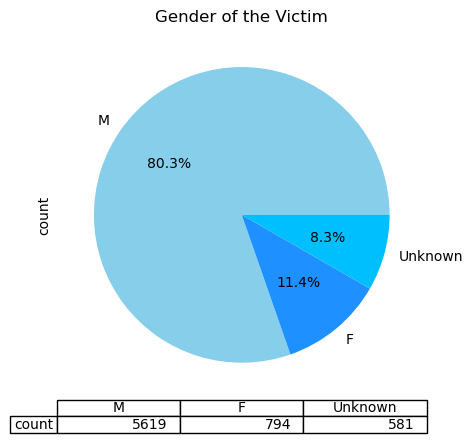

In [165]:
# Piechart to see the distribution between "M", "F". 
df[df["Gender"].isin(["M", "F", "Unknown"])]["Gender"].value_counts().plot(kind="pie", title= "Gender of the Victim", autopct="%1.1f%%", colors=["skyblue", "dodgerblue", "deepskyblue"], table=True)

In [17]:
country_gender = df.groupby(["Gender", "Country"]).size().to_frame("count").reset_index()
country_gender

,Gender,Country,count
0,F,ATLANTIC OCEAN,3
1,F,AUSTRALIA,112
2,F,Australia,2
3,F,BAHAMAS,26
4,F,BELIZE,2
...,...,...,...
373,Unknown,URUGUAY,1
374,Unknown,USA,105
375,Unknown,VANUATU,1
376,Unknown,YEMEN,1


# Data Cleaning for the Column 'Species'

In [139]:
df["Species"].unique()
print(df["Species"].unique()[:600])

['Unknown' 'Bull shark' 'Bronze whaler' 'Reportedly Tiger or Bull shark'
 'Great White Shart estimated ' 'Reportedly a Tiger Shark' 'Unknown '
 'm shark species unknown' 'Great White Shark'
 'Reported as a large Tiger shark' 'Bull or tiger ' 'Bull shark '
 'Reportedly a Great White' 'Reportedly Tiger Shark' 'Reef shark '
 'm White Shark' 'Undetermined small shall shark' '-' 'Not specified'
 ' ft shark' 'ft shark' 'Not stated area has Tiger and Galapogas sharks'
 'Not specified Bull shark highly suspect' 'Large shark' 'm shark'
 'm Sandbar shark' 'Carribean reef shark ' 'Great White' 'Tiger shark'
 'Tiger shark ' ' to ' 'Blacktip reef shark' 'White shark'
 'Raggedtooth shark' 'Broze whaler' 'Sevengill shark'
 'Shark involment not confirmed' 'm bull shark' 'Lemon shark'
 'Oceanic whitetip shark' 'White Shark' ' tiger shark' 'Nurse shark'
 'Cookiecutter sharks' 'Blue shark' 'Wfite shark' 'Wobbegong shark'
 ' shark' 'Sand tiger shark' 'Tiger sharks' 'Caribbean rreef shark'
 'Grey reef shar

In [18]:
# Cleaning the Column 'Species' a bit 
df["Species"] = df["Species"].str.extract(r'([A-Za-z\s-]+)').fillna("Unknown") # Cleaning here the unnecessary details
df["Species"] = df["Species"].replace({
    "Not stated":"Unknown"
})
print(df["Species"])

0             Unknown
1          Bull shark
2             Unknown
3       Bronze whaler
4             Unknown
            ...      
6989          Unknown
6990          Unknown
6991          Unknown
6992          Unknown
6993          Unknown
Name: Species, Length: 6994, dtype: object


In [19]:
df["Species_Types"] = df["Species"].copy() # creating a copy of species and naming it Species_Types

In [20]:
df["Species_Types"] = df["Species_Types"].fillna("Unknown").astype(str)

In [22]:
df["Species_Types"] = df["Species_Types"].replace({
    "Not stated": "Unknown",
    "Not specified": "Unknown",
    "Invalid": "Unknown",
    "Great White Shark": "White Shark"   
}) 

In [24]:
#Data Cleanining for the Column 'Species'
#df["Species"].unique() df["Species"] = df["Species"]
#df["Species"]
#df.Species.unique()

def clean_shark_name(species): 
    species = species.strip().lower()

    match = re.search(r"(?:\b\w+\s+)*?(great white|horn|white|tiger|bull|Bull|hammerhead|hammer|Hammerhead|blacktip|whale|nurse|mako|reef|Reef)(?:\s+\w+)*?\s*shark(?:\s+\w+)*?", species)
    #match = re.search(r"(great white|white|tiger|bull|hammerhead|blacktip|whale|nurse|mako|reef)s*shark", species)

    if match:
        #return match.group(0).title()
        return match.group(1).title() + " Shark"
    else: 
        return "Other/Unknown"

df["Species_Types"] = df["Species_Types"].apply(clean_shark_name)

print(df["Species_Types"].value_counts())  # Check unique values
print(df["Species_Types"].tail())  # Display first few rows
#print(df_Species.nunique()) 
#print(df_Species.unique()[:100])

Species_Types
Other/Unknown       5567
White Shark          552
Tiger Shark          314
Bull Shark           197
Nurse Shark          110
Blacktip Shark       101
Reef Shark            57
Mako Shark            56
Hammerhead Shark      37
Whale Shark            3
Name: count, dtype: int64
6989    Other/Unknown
6990    Other/Unknown
6991    Other/Unknown
6992    Other/Unknown
6993    Other/Unknown
Name: Species_Types, dtype: object


In [148]:
#df.dtypes
df["Species_Types"].value_counts()

Species_Types
Other/Unknown       5567
White Shark          552
Tiger Shark          314
Bull Shark           197
Nurse Shark          110
Blacktip Shark       101
Reef Shark            57
Mako Shark            56
Hammerhead Shark      37
Whale Shark            3
Name: count, dtype: int64

In [147]:
df["Species_Types"] = df["Species_Types"].str.strip()

In [146]:
print(df["Species_Types"].value_counts())

Species_Types
Other/Unknown       5567
White Shark          552
Tiger Shark          314
Bull Shark           197
Nurse Shark          110
Blacktip Shark       101
Reef Shark            57
Mako Shark            56
Hammerhead Shark      37
Whale Shark            3
Name: count, dtype: int64


## Visualisation for Shark Types

In [151]:
species_types_grp = df.groupby("Species_Types")
shark_attack_by_species_types = species_types_grp["Species_Types"].count()
shark_attack_by_species_types = shark_attack_by_species_types.sort_values(ascending=False)
top_species_types_attack = shark_attack_by_species_types.head(15)
top_species_types_attack

Species_Types
Other/Unknown       5567
White Shark          552
Tiger Shark          314
Bull Shark           197
Nurse Shark          110
Blacktip Shark       101
Reef Shark            57
Mako Shark            56
Hammerhead Shark      37
Whale Shark            3
Name: Species_Types, dtype: int64

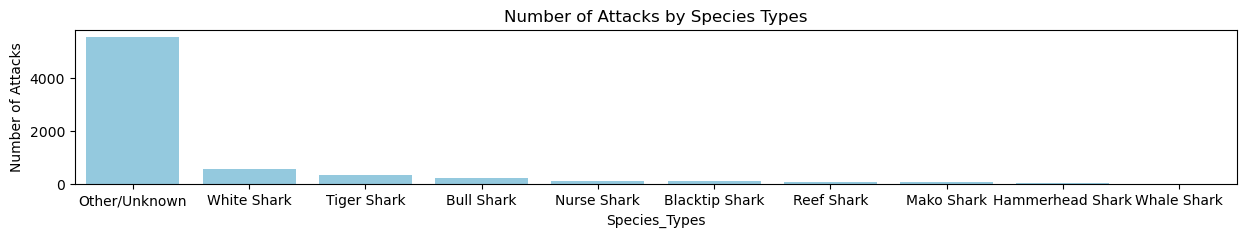

In [167]:
plt.figure(figsize=(15,2))
sns.barplot(x=top_species_types_attack.index, y=top_species_types_attack, color="skyblue")
plt.title("Number of Attacks by Species Types")
plt.ylabel("Number of Attacks")
plt.show()

In [ ]:
# This can be ignored, but can be usable for in the future
#Group_Species = df.groupby("Species")

#for species, group in Group_Species:
#    print(f"Group name: {species}")
#   # display(group)
#df["Species"].nunique() == len(Grouped_Species)

In [ ]:
#df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Data Cleaning for the 'Country' Column

In [41]:
df["Country"].unique()

array(['Turks and Caicos', 'Australia', 'USA', 'New Caledonia', 'Egypt',
       'Thailand', 'New Zealand', 'Maldives', 'Hawaii', 'Honduras',
       'Morocco', 'Jamaica', 'Belize', 'Maldive Islands',
       'French Polynesia', 'Tobago', 'Bahamas', 'AUSTRALIA', 'INDIA',
       'TRINIDAD', 'BAHAMAS', 'SOUTH AFRICA', 'MEXICO', 'NEW ZEALAND',
       'EGYPT', 'Mexico', 'BELIZE', 'PHILIPPINES', 'Coral Sea', 'SPAIN',
       'PORTUGAL', 'SAMOA', 'COLOMBIA', 'ECUADOR', 'FRENCH POLYNESIA',
       'NEW CALEDONIA', 'TURKS and CaICOS', 'CUBA', 'BRAZIL',
       'SEYCHELLES', 'ARGENTINA', 'FIJI', 'MeXICO', 'South Africa',
       'ENGLAND', 'JAPAN', 'INDONESIA', 'JAMAICA', 'MALDIVES', 'THAILAND',
       'COLUMBIA', 'COSTA RICA', 'British Overseas Territory', 'CANADA',
       'JORDAN', 'ST KITTS / NEVIS', 'ST MARTIN', 'PAPUA NEW GUINEA',
       'REUNION ISLAND', 'ISRAEL', 'CHINA', 'IRELAND', 'ITALY',
       'MALAYSIA', 'LIBYA', nan, 'MAURITIUS', 'SOLOMON ISLANDS',
       'ST HELENA, British overseas ter

In [40]:
len(df["Country"].unique())

240

In [84]:
update_country = {
    'AUSTRALIA': 'Australia',
    'BAHAMAS': 'Bahamas',
    'BELIZE': 'Belize',
    'COLOMBIA': 'Colombia',
    'COLUMBIA': 'Colombia',
    'EGYPT': 'Egypt',
    'ENGLAND': 'United Kingdom',
    'FRENCH POLYNESIA': 'French Polynesia',
    'INDIA': 'India',
    'INDONESIA': 'Indonesia',
    'JAMAICA': 'Jamaica',
    'JAPAN': 'Japan',
    'MALDIVE ISLANDS': 'Maldives',
    'MALDIVES': 'Maldives',
    'MEXICO': 'Mexico',
    'MeXICO': 'Mexico',
    'MEXICO ': 'Mexico',
    'NEW CALEDONIA': 'New Caledonia',
    'NEW ZEALAND': 'New Zealand',
    'PHILIPPINES': 'Philippines',
    'SPAIN': 'Spain',
    'SOUTH AFRICA': 'South Africa',
    'South Africa': 'South Africa',
    'THAILAND': 'Thailand',
    'TRINIDAD': 'Trinidad and Tobago',
    'TRINIDAD & TOBAGO': 'Trinidad and Tobago',
    'TURKS & CAICOS': 'Turks and Caicos',
    'TURKS and CaICOS': 'Turks and Caicos',
    'UNITED ARAB EMIRATES (UAE)': 'United Arab Emirates',
    'UNITED KINGDOM': 'United Kingdom',
    'USA': 'United States',
    'UAE': 'United Arab Emirates',
    'UNITED STATES': 'United States',
    'REUNION ISLAND': 'Reunion',
    'REUNION': 'Reunion',
    'ST MARTIN': 'Saint Martin',
    'ST. MARTIN': 'Saint Martin',
    'ST. MAARTIN': 'Saint Martin',
    'SAINT MAARTEN': 'Saint Martin',
    'PAPUA NEW GUINEA': 'Papua New Guinea',
    'FIJI': 'Fiji',
    'Fiji': 'Fiji',
    'CANADA': 'Canada',
    'CUBA': 'Cuba',
    'ARGENTINA': 'Argentina',
    'BRAZIL': 'Brazil',
    'CHILE': 'Chile',
    'ECUADOR': 'Ecuador',
    'PERU': 'Peru',
    'VENEZUELA': 'Venezuela',
    'COOK ISLANDS': 'Cook Islands',
    'DOMINICAN REPUBLIC': 'Dominican Republic',
    'SEYCHELLES': 'Seychelles',
    'ST KITTS / NEVIS': 'Saint Kitts and Nevis',
    'ST HELENA, British overseas territory': 'Saint Helena',
    'SOLOMON ISLANDS': 'Solomon Islands',
    'TONGA': 'Tonga',
    ' TONGA': 'Tonga',
    'KIRIBATI': 'Kiribati',
    'PALAU': 'Palau',
    'MALTA': 'Malta',
    'SCOTLAND': 'United Kingdom',
    'IRELAND': 'Ireland',
    'ITALY': 'Italy',
    'MALAYSIA': 'Malaysia',
    'LIBYA': 'Libya',
    'JORDAN': 'Jordan',
    'ISRAEL': 'Israel',
    'CHINA': 'China',
    'TAIWAN': 'Taiwan',
    'INDIAN OCEAN': 'Indian Ocean',
    'INDIAN OCEAN?': 'Indian Ocean',
    'INDIAN OCEAN?': 'Indian Ocean',
    'NORTH ATLANTIC OCEAN': 'North Atlantic Ocean',
    'NORTH ATLANTIC OCEAN ': 'North Atlantic Ocean',
    'SOUTH ATLANTIC OCEAN': 'South Atlantic Ocean',
    'ATLANTIC OCEAN': 'Atlantic Ocean',
    'PACIFIC OCEAN': 'Pacific Ocean',
    'PACIFIC OCEAN ': 'Pacific Ocean',
    'SOUTH PACIFIC OCEAN': 'South Pacific Ocean',
    'NORTH PACIFIC OCEAN': 'North Pacific Ocean',
    'CARIBBEAN SEA': 'Caribbean Sea',
    'MID ATLANTIC OCEAN': 'Mid Atlantic Ocean',
    'SOUTH CHINA SEA': 'South China Sea',
    'BAY OF BENGAL': 'Bay of Bengal',
    'RED SEA': 'Red Sea',
    'RED SEA?': 'Red Sea',
    'RED SEA / INDIAN OCEAN': 'Red Sea',
    'GULF OF ADEN': 'Gulf of Aden',
    'PERSIAN GULF': 'Persian Gulf',
    'CEYLON': 'Sri Lanka',
    'CEYLON (SRI LANKA)': 'Sri Lanka',
    'SRI LANKA': 'Sri Lanka',
    'BANGLADESH': 'Bangladesh',
    'BURMA': 'Myanmar',
    'MYANMAR': 'Myanmar',
    'VIETNAM': 'Vietnam',
    'HONG KONG': 'Hong Kong',
    'MARTINIQUE': 'Martinique',
    'NETHERLANDS ANTILLES': 'Netherlands Antilles',
    'NORTHERN MARIANA ISLANDS': 'Northern Mariana Islands',
    'FEDERATED STATES OF MICRONESIA': 'Micronesia',
    'MICRONESIA': 'Micronesia',
    'FALKLAND ISLANDS': 'Falkland Islands',
    'GIBRALTAR': 'Gibraltar',
    'SAUDI ARABIA': 'Saudi Arabia',
    'SINGAPORE': 'Singapore',
    'SENEGAL': 'Senegal',
    'SOMALIA': 'Somalia',
    'SOUTH KOREA': 'South Korea',
    'NORTH KOREA': 'North Korea',
    'RUSSIA': 'Russia',
    'GREECE': 'Greece',
    'TUNISIA': 'Tunisia',
    'TURKEY': 'Turkey',
    'IRAN': 'Iran',
    'IRAQ': 'Iraq',
    'KUWAIT': 'Kuwait',
    'LEBANON': 'Lebanon',
    'SYRIA': 'Syria',
    'AFRICA': 'Africa',
    'Coast of AFRICA': 'Africa',
    'GEORGIA': 'Georgia',
    'GHANA': 'Ghana',
    'GUINEA': 'Guinea',
    'NAMIBIA': 'Namibia',
    'TANZANIA': 'Tanzania',
    'ALGERIA': 'Algeria',
    'DJIBOUTI': 'Djibouti',
    'EQUATORIAL GUINEA / CAMEROON': 'Equatorial Guinea',
    'WEST INDIES': 'Caribbean',
    'BRITISH ISLES': 'United Kingdom',
    'BRITISH WEST INDIES': 'Caribbean',
    'ST HELENA, British overseas territory': 'Saint Helena',
    'NORWAY': 'Norway',
    'ICELAND': 'Iceland',
    'GABON': 'Gabon',
    'MAYOTTE': 'Mayotte',
    'SWEDEN': 'Sweden',
    'SLOVENIA': 'Slovenia',
    'CURACAO': 'Curaçao',
    'HAITI': 'Haiti',
    'GUATEMALA': 'Guatemala',
    'NICARAGUA': 'Nicaragua',
    'NICARAGUA ': 'Nicaragua',
    'HONDURAS': 'Honduras',
    'EL SALVADOR': 'El Salvador',
    'COSTA RICA': 'Costa Rica',
    'PANAMA': 'Panama',
    'BARBADOS': 'Barbados',
    'ARUBA': 'Aruba',
    'GRAND CAYMAN': 'Cayman Islands',
    'CAYMAN ISLANDS': 'Cayman Islands',
    'SAINT LUCIA': 'Saint Lucia',
    'USA': 'United States', 
    'Usa': 'United States'
}


In [85]:
df['Country'] = df['Country'].replace(update_country).fillna('Unknown')

In [86]:
df['Country'].unique()

array(['Turks And Caicos', 'Australia', 'United States', 'New Caledonia',
       'Egypt', 'Thailand', 'New Zealand', 'Maldives', 'Hawaii',
       'Honduras', 'Morocco', 'Jamaica', 'Belize', 'Maldive Islands',
       'French Polynesia', 'Tobago', 'Bahamas', 'India', 'Trinidad',
       'South Africa', 'Mexico', 'Philippines', 'Coral Sea', 'Spain',
       'Portugal', 'Samoa', 'Colombia', 'Ecuador', 'Cuba', 'Brazil',
       'Seychelles', 'Argentina', 'Fiji', 'England', 'Japan', 'Indonesia',
       'Columbia', 'Costa Rica', 'British Overseas Territory', 'Canada',
       'Jordan', 'St Kitts / Nevis', 'St Martin', 'Papua New Guinea',
       'Reunion Island', 'Israel', 'China', 'Ireland', 'Italy',
       'Malaysia', 'Libya', 'Unknown', 'Mauritius', 'Solomon Islands',
       'St Helena, British Overseas Territory', 'Comoros', 'Reunion',
       'United Kingdom', 'United Arab Emirates', 'Cape Verde',
       'Dominican Republic', 'Cayman Islands', 'Aruba', 'Mozambique',
       'Puerto Rico', 'Atla

In [140]:
# Data Cleaning for the column 'Country', I've tried to use regex 
df["Country"] = df["Country"].str.strip().str.title()
#df["Country"] = df["Country"].str.replace(r"[^a-zA-Z\s]", "", regex=True)
#df["Country"] = df["Country"].map(lambda x: x.upper())
df["Country"] = df["Country"].fillna("Unknown")
print(df["Country"].unique())

['Turks And Caicos' 'Australia' 'United States' 'New Caledonia' 'Egypt'
 'Thailand' 'New Zealand' 'Maldives' 'Hawaii' 'Honduras' 'Morocco'
 'Jamaica' 'Belize' 'Maldive Islands' 'French Polynesia' 'Tobago'
 'Bahamas' 'India' 'Trinidad' 'South Africa' 'Mexico' 'Philippines'
 'Coral Sea' 'Spain' 'Portugal' 'Samoa' 'Colombia' 'Ecuador' 'Cuba'
 'Brazil' 'Seychelles' 'Argentina' 'Fiji' 'England' 'Japan' 'Indonesia'
 'Columbia' 'Costa Rica' 'British Overseas Territory' 'Canada' 'Jordan'
 'St Kitts / Nevis' 'St Martin' 'Papua New Guinea' 'Reunion Island'
 'Israel' 'China' 'Ireland' 'Italy' 'Malaysia' 'Libya' 'Unknown'
 'Mauritius' 'Solomon Islands' 'St Helena, British Overseas Territory'
 'Comoros' 'Reunion' 'United Kingdom' 'United Arab Emirates' 'Cape Verde'
 'Dominican Republic' 'Cayman Islands' 'Aruba' 'Mozambique' 'Puerto Rico'
 'Atlantic Ocean' 'Greece' 'St. Martin' 'France' 'Trinidad & Tobago'
 'Kiribati' 'Diego Garcia' 'Taiwan' 'Palestinian Territories' 'Guam'
 'Nigeria' 'Tonga' 'Scotl

In [141]:
unique_country = len(df['Country'].unique())
unique_country

212

In [142]:
df["Country"] = df["Country"].replace(update_country) # Reassigning it back to "Country"

In [90]:
country_grp = df.groupby('Country')
number_of_attacks = country_grp['Country'].count()
number_of_attacks = number_of_attacks.sort_values(ascending=False)
top_10_attacks = number_of_attacks.head(10)
top_10_attacks

Country
United States       2556
Australia           1494
South Africa         598
New Zealand          146
Bahamas              137
Papua New Guinea     136
Brazil               122
Mexico               106
Italy                 72
Fiji                  70
Name: Country, dtype: int64

## Visuallisation of Top 10 Countries of Shark Attacks

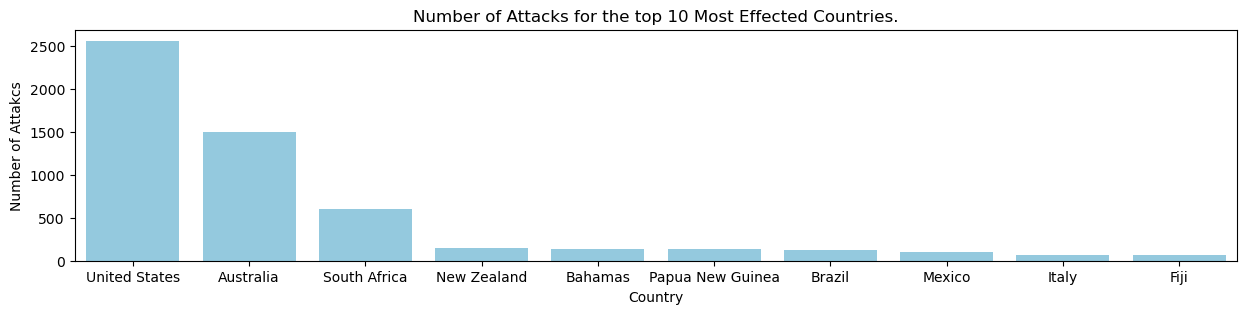

In [91]:
plt.figure(figsize=(15,3))
sns.barplot(x=top_10_attacks.index, y=top_10_attacks, color="skyblue")
plt.title("Number of Attacks for the top 10 Most Effected Countries.")
plt.ylabel("Number of Attakcs")
plt.show()

## Visualisation: Gender Distribution of Victims of Shark Attacks.

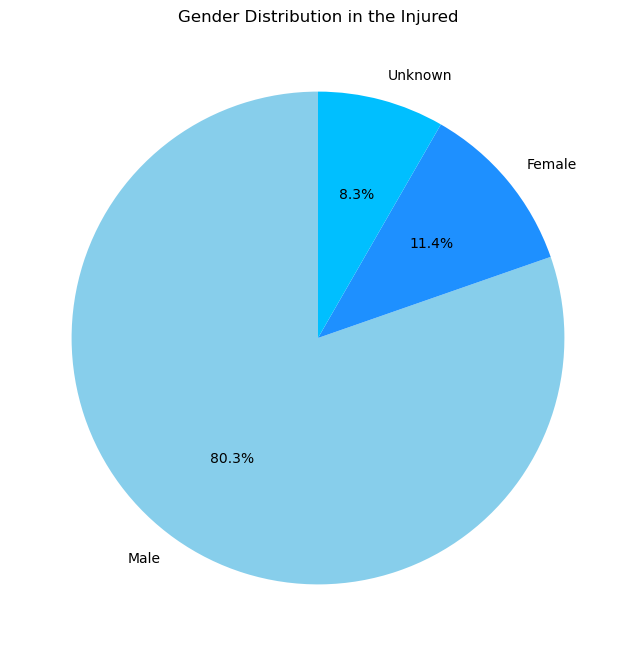

In [ ]:
df["Gender"] = df["Gender"].fillna("Unknown")  # Replace NaN with "Unknown"

gender_grp = df.groupby("Gender")
gender_country_grp = gender_grp["Country"].count()
gender_of_injured = gender_country_grp.sort_values(ascending=False)
gender_of_injured.index = gender_of_injured.index.map({"M": "Male", "F": "Female"}).fillna("Unknown")  # Map known values and keep "Unknown"

plt.figure(figsize=(8, 8))
plt.pie(gender_of_injured, labels=gender_of_injured.index, autopct="%1.1f%%", startangle=90, colors=["skyblue", "dodgerblue", "deepskyblue"])
plt.title("Gender Distribution in the Injured")
plt.show()

# Data Cleaning for the Column 'Location'

In [29]:
# Cleaning for location
df["Location"] = df["Location"].astype(str)
df["Location"] = df["Location"].map(lambda x:x.upper())
df["Location"] = df["Location"].fillna("Unknown")
df["Location"] = df["Location"].str.strip()
df["Location"] = df["Location"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown", 
})
df["Location"] 

0                       THOMPSON COVE BEACH
1              WOORIM BEACH, BRIBIE ISLAND,
2                            SHIPWRECK COVE
3                             CHEYNES BEACH
4             OFF HALEIWA BOAT HARBOUR OAHU
                       ...                 
6989                            ROEBUCK BAY
6990                                Unknown
6991                         OCRACOKE INLET
6992                   PANAMA BAY 8ºN, 79ºW
6993    BELOW THE ENGLISH FORT, TRINCOMALEE
Name: Location, Length: 6994, dtype: object

In [30]:
# Data Cleaning for the Column 'State'
#df["State"] = df["State"].
df["State"] = df["State"].fillna("Unknown")
df["State"] = df["State"].astype(str)
df["State"] = df["State"].str.strip()
df["State"] = df["State"].replace({
    "NAN": "Unknown",
    "nan": "Unknown",
    "Nan": "Unknown", 
    " ": "Unknown",
    "  ": "Unknown"
})
print(df["State"].unique())

['Unknown' 'Queensland' 'Western Australia' 'Hawaii' 'Grande Terre'
 'South Australia' 'North of Marsa Alam' 'Phang Nga Province'
 'Bay of Waitangi' 'Kaafu' 'Maui' 'Florida' 'Tela' 'Trujillo Colon'
 'Southern Morocco' 'Montego Bay' 'Gulf of Honduras' 'NSW' 'Texas'
 'Floria' 'California' 'Maahvah Laamu Atoll' 'Galveston'
 'Providenciales Island' 'Gambier Islands' 'South Carolina'
 'Graet Courland Bay' 'Clarence Town Long Isand' 'Nunu Atoll'
 'Maharashtra' 'New  South Wales' 'Paradise Island'
 'Eastern Cape Province' 'Sonora' 'New South Wales' 'South Island'
 'Guerrero' 'New Providence   Isoad' 'Jalisco' 'Grand  Bahama Island'
 'Westerm Australia' 'North Island' 'Southern Red Sea' 'Quintana Roo'
 'Belize District' 'South Sinai' 'Bolinao' 'North Carolina' 'Valencia'
 'Norte' "Savai'i island" 'New York' 'San Andrés Island'
 'Galapagos Islands' 'Red Sea Protectorate' 'Freeport' 'Tahiti' 'Poum'
 'Lucayan Lucayan Archipelago' 'Utah' 'New Jersey' 'Mayabeque'
 'Easten Cape Province' 'Artemisa' 

In [31]:
# Data Cleaning for the Column Activity 
df["Activity"] = df["Activity"].fillna("Unknown")
df["Activity"] = df["Activity"].astype(str)
df["Activity"] = df["Activity"].str.strip()
df["Activity"] = df["Activity"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown",
})
# Needs more cleaning 

In [169]:
df.isna().sum()

Date                 0
Year                 2
Type                 0
Country              0
State                0
Location             0
Activity             0
Name               219
Gender               0
Age                  0
Injury              35
Fatal                0
Time              3526
Species              0
Source              19
Href               198
Original_Order     195
Species_Types        0
dtype: int64

In [176]:
df['Activity'].unique()[:100]

array(['Swimming', 'Bathing', 'Surfing', 'Diving', 'Spearfishing',
       'SCUBA Diving', 'Snorkeling', 'Diving for shellfish',
       'Swimming - jumped off yacht', 'Swimming - Diving',
       'Diving into Water', 'Wading', 'Playing football in the water',
       'Unconfirmed Possibly swimming near the boat harbour',
       'Swimming ocean training', 'Military ocean training',
       'snorkelling', 'Freediving',
       'Jumpinf from dock to boat acidentally fell into water at marina',
       'Fishing', 'Free diving', 'Foil Boarding', 'Paddle boarding',
       'Scuba diving', 'On a round-the-world expedition', 'Kayak fishing',
       'Unknown', 'Towing a dead whale out to sea', 'Boogie boarding',
       'Sitting', 'Watching the sardine run', 'Standing', 'Filming',
       'Kite surfing', 'Jumped overboard', 'Shark Feeding',
       'Diving for crayfish', 'Windsurfing', 'Kite-Surfing', 'Surf-sking',
       'Diving with  surface-supplied air', 'Spearishing',
       'Snorkeling at Shark Fee

In [188]:
def clean_activity(activity): 
    if not isinstance(activity, str):  # Handle NaN values
        return "Other/Unknown"
    
    activity = activity.strip().lower()  # Normalize text
    
    pattern = r"(?:\b\w+\s+)*?\b(surfing|swimming|fishing|paddle(?:boarding)?|snorkeling|Shark|diving|kayaking|bathing|bodyboarding|spearfishing|boogie boarding|wading|floating|scuba diving|free diving|wakeboarding|windsurfing|sailing|jet skiing|canoeing|rafting|water skiing)(?:\s+\w+)*?\b"
    
    match = re.search(pattern, activity, re.IGNORECASE)  # Applying regex
    
    if match:
        return match.group(1).title()  # Capitalize the matched activity
    else: 
        return "Other/Unknown"

# Apply function to the dataframe
df['Cleaned_Activity'] = df['Activity'].apply(clean_activity)

# Check the results
print(df["Cleaned_Activity"].value_counts())  # Count occurrences of each category
print(df["Cleaned_Activity"].tail())  # Displaying last few rows


Cleaned_Activity
Other/Unknown      1786
Surfing            1264
Swimming           1235
Fishing             763
Spearfishing        464
Diving              349
Wading              197
Bathing             192
Snorkeling          137
Shark               136
Scuba Diving        133
Free Diving          92
Boogie Boarding      62
Floating             51
Kayaking             48
Windsurfing          22
Canoeing             17
Paddle               16
Sailing              14
Paddleboarding       12
Jet Skiing            2
Bodyboarding          1
Wakeboarding          1
Name: count, dtype: int64
6989           Diving
6990           Diving
6991         Swimming
6992    Other/Unknown
6993         Swimming
Name: Cleaned_Activity, dtype: object


In [189]:
df['Cleaned_Activity'].unique()[:100]

array(['Swimming', 'Bathing', 'Surfing', 'Diving', 'Spearfishing',
       'Scuba Diving', 'Snorkeling', 'Wading', 'Other/Unknown', 'Fishing',
       'Free Diving', 'Paddle', 'Boogie Boarding', 'Shark', 'Windsurfing',
       'Kayaking', 'Paddleboarding', 'Floating', 'Canoeing', 'Sailing',
       'Bodyboarding', 'Jet Skiing', 'Wakeboarding'], dtype=object)

In [190]:
df["Cleaned_Activity"].value_counts()

Cleaned_Activity
Other/Unknown      1786
Surfing            1264
Swimming           1235
Fishing             763
Spearfishing        464
Diving              349
Wading              197
Bathing             192
Snorkeling          137
Shark               136
Scuba Diving        133
Free Diving          92
Boogie Boarding      62
Floating             51
Kayaking             48
Windsurfing          22
Canoeing             17
Paddle               16
Sailing              14
Paddleboarding       12
Jet Skiing            2
Bodyboarding          1
Wakeboarding          1
Name: count, dtype: int64

In [ ]:
df["Cleaned_Activity"] = df["Cleaned_Activity"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown"
})

In [ ]:
# Data Cleaning for the Column 'Name' 
df["Activity"] = df["Activity"].fillna("Unknown")
df["Activity"] = df["Activity"].astype(str)
df["Activity"] = df["Activity"].str.strip()
df["Activity"] = df["Activity"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown"
})
df["Activity"]
# Needs to be furthered cleaned 

0           Swimming
1           Swimming
2            Bathing
3            Surfing
4             Diving
            ...     
6989          Diving
6990    Pearl diving
6991        Swimming
6992         Unknown
6993        Swimming
Name: Activity, Length: 6994, dtype: object

In [179]:
len(df['Activity'].unique())

1568

In [34]:
# Data Cleaning for the Column Age
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["Age"].describe()

count    3863.000000
mean       28.104841
std        14.578246
min         1.000000
25%        17.000000
50%        24.000000
75%        37.000000
max        87.000000
Name: Age, dtype: float64

In [35]:
# Since the Mean is 28.104841, I am going to replace it with all the null values, without greatily altering the distribution of the "Age" Column. 
df["Age"] = df["Age"].fillna(28.104841)
df["Age"]

0       55.000000
1       17.000000
2       12.000000
3       37.000000
4       23.000000
          ...    
6989    28.104841
6990    28.104841
6991    28.104841
6992    28.104841
6993    15.000000
Name: Age, Length: 6994, dtype: float64

## Visualtisation for Data & Age

Text(0.5, 1.0, 'Age Distribution')

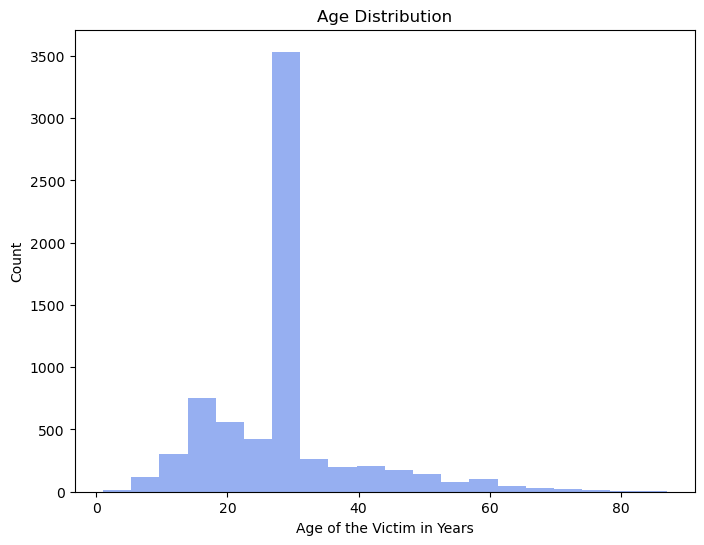

In [36]:
# I am graphicing here the Data & Age
fix, ax = plt.subplots(figsize=(8,6))
ax = sns.distplot(df["Age"],
ax = ax, 
hist_kws = {"alpha": 0.6, "color": "#517AE9"}, 
kde=False, bins=20)
plt.xlabel("Age of the Victim in Years")
plt.ylabel("Count")
plt.title("Age Distribution")

Text(0.5, 0.98, 'Relationships between Age, Year and Original Order')

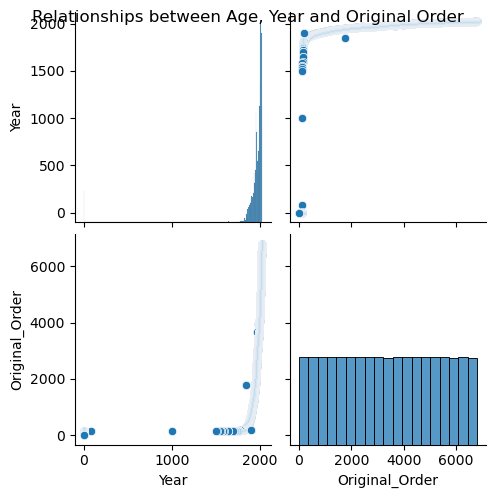

In [ ]:
#sns.pairplot(df)
#plt.suptitle("Relationships between Age, Year and Original Order")

# Fatal Rate of Shark Attacks 

In [101]:
df["Fatal"].unique()

array(['N', 'Y', 'F', 'M', nan, 'n', 'Nq', 'UNKNOWN', 2017, 'Y x 2', ' N',
       'N ', 'y'], dtype=object)

In [128]:
df["Fatal"] = df["Fatal"].fillna("Unknown").str.strip().astype(str)

In [ ]:
# Data Cleaning for The Column Fatal
df["Fatal"] = df["Fatal"].fillna("Unknown")
df["Fatal"] = df["Fatal"].str.strip()
df["Fatal"].value_counts(dropna=False)
df["Fatal"] = df["Fatal"].astype(str)
df["Fatal"] = df["Fatal"].replace({
    "Nan": "Unknown",
    " N": "NO",
    "UNKNOWN": "Unknown",
    "F": "Unknown",\
    "M": "NO",
    "n": "NO",
    "N": "NO",
    "Nq": "NO",
    "Y": "YES",
    2017: "Unknown",
    "2017 ": "Unknown",
     "Y x 2": "Yes",
     "y": "Yes",
     "N   ": "NO",
})
#df["Fatal"] = df["Fatal"]
#df["Fatal"] = df["Fatal"]
#df["Fatal"] = df["Fatal"]
df["Fatal"].unique()


array(['No', 'YES', 'Unknown'], dtype=object)

In [124]:
gender_grp = df.groupby("Fatal")
gender_grp.count()

,Date,Year,Type,Country,State,Location,Activity,Name,Gender,Age,Injury,Time,Species,Source,Href,Original_Order,Species_Types
Fatal,,,,,,,,,,,,,,,,,
No,4886,4886,4886,4886,4886,4886,4886,4813,4886,4886,4880,2738,4886,4873,4726,4729,4886
Unknown,637,636,637,637,637,637,637,569,637,637,609,167,637,631,630,630,637
YES,1471,1470,1471,1471,1471,1471,1471,1393,1471,1471,1470,563,1471,1471,1440,1440,1471


## Visualisation: Fatal Rate of Shark Attacks 

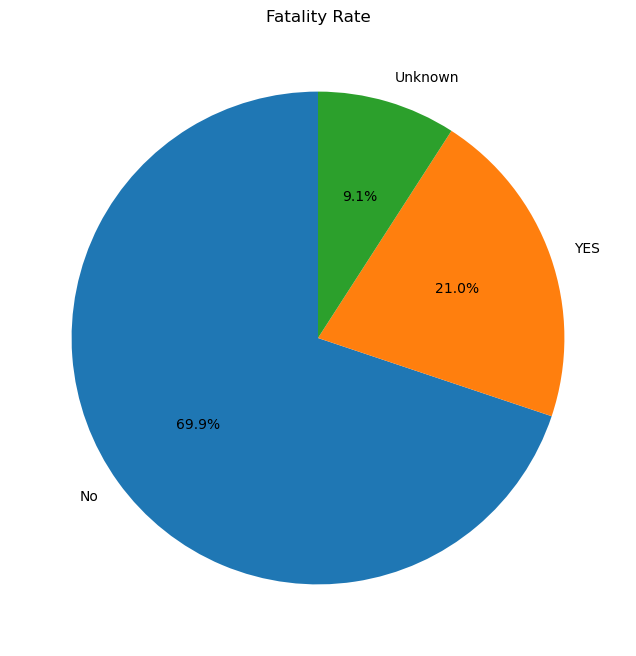

In [ ]:
# Plot Pie Chart Column and COunt of Occurrences 

# Grouping by Fatal Column and Count Occurrences 
fatal_counts = df["Fatal"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(fatal_counts, labels=fatal_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Fatality Rate")
plt.show()

# Fatality Rate by Gender

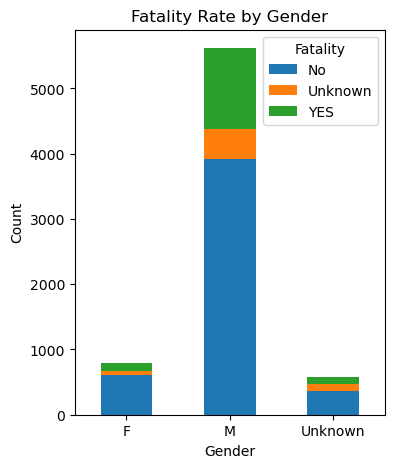

In [137]:
# Group by gender and Fatality Rate
gender_fatal_counts = df.groupby(["Gender", "Fatal"]).size().unstack()

# Plot Stacked Bar Chart
gender_fatal_counts.plot(kind="bar", stacked=True, figsize=(4, 5))

plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Fatality Rate by Gender")
plt.legend(title="Fatality", labels=gender_fatal_counts.columns)
plt.xticks(rotation=0)
plt.show()

In [38]:
df_count = df.groupby("Year")["Date"].count()
df_count

Year
0.0       129
5.0         1
77.0        1
1000.0      1
1500.0      1
         ... 
2022.0     98
2023.0    109
2024.0     49
2025.0      8
2026.0      1
Name: Date, Length: 261, dtype: int64

# Data Cleaning for the Column 'Date'

In [39]:
df["Date"].value_counts()

Date
1957           9
1942           8
1958           7
No date        6
1941           6
              ..
19-Sep-2000    1
24-Sep-2000    1
25-Sep-2000    1
29-Sep-2000    1
1845-1853      1
Name: count, Length: 6042, dtype: int64

## Visualisation for Date

<Axes: xlabel='Year'>

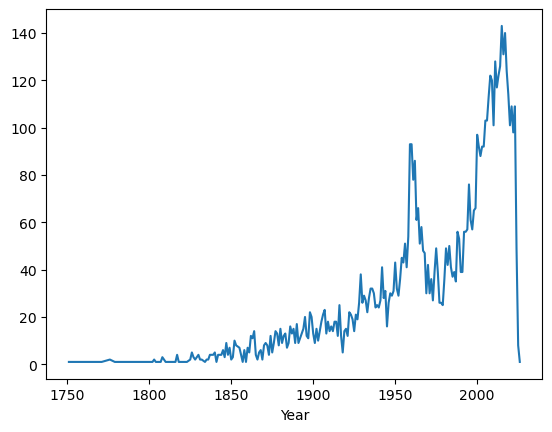

In [37]:
df_count = df.groupby("Year")["Date"].count()
df_count[df_count.index > 1750].plot()

In [40]:
df_count#.isna().sum()

Year
0.0       129
5.0         1
77.0        1
1000.0      1
1500.0      1
         ... 
2022.0     98
2023.0    109
2024.0     49
2025.0      8
2026.0      1
Name: Date, Length: 261, dtype: int64

In [43]:
df["Country"].value_counts()

Country
USA                   2556
AUSTRALIA             1481
SOUTH AFRICA           597
NEW ZEALAND            144
PAPUA NEW GUINEA       136
                      ... 
EGYPT / ISRAEL           1
Seychelles               1
GRAND CAYMAN             1
ST. MAARTIN              1
CEYLON (SRI LANKA)       1
Name: count, Length: 239, dtype: int64

In [44]:
df_usa = df[df["Country"] == "USA"]
df_usa

,Date,Year,Type,Country,State,Location,Activity,Name,Gender,Age,...,Source,PDF,Href_formula,Href,Case_Number,Case_Number_1,Original_Order,Unnamed_21,Unnamed_22,Species_Types
4,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,...,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Unknown
17,2024-10-25 00:00:00,2024.0,Unprovoked,USA,Florida,"Bathtub Beach, Martin County",Surfing,Cole Taschman,M,27,...,Bob Myatt: Yardbarker: 12 on your side: WPTV: ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Unknown
19,2024-10-11 00:00:00,2024.0,Unprovoked,USA,Florida,Brevard County Orlando,Surfing,Teddy Witteman,M,16,...,Todd SmithFlorida today: News 4:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bull Shark
26,2024-07-08 00:00:00,2024.0,Unprovoked,USA,Florida,Ponce de Leon Inlet Volusia County,Diving into Water,Dempsey Manhart,M,14,...,Miami Herald,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Unknown
27,2024-07-05 00:00:00,2024.0,Unprovoked,USA,Florida,New Smyrna Beach,Wading,Not stated,M,26,...,Sacbee Fox 35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6941,Before 1958,0.0,Unprovoked,USA,Florida,"Palm Beach, Palm Beach County",Standing,Horton Chase,M,NaN,...,"V.M. Coppleson (1956), p.255; R.F. Hutton",ND-0056-HortonChase.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0056,ND.0056,54.0,NaN,NaN,Other/Unknown
6975,Before 1921,0.0,Unprovoked,USA,Florida,"Gadsden Point, Tampa Bay",Fishing,James Kelley,M,NaN,...,"T. Helm, p.219",ND-0019-Kelley.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0019,ND.0019,20.0,NaN,NaN,Other/Unknown
6980,Before 17-Jul-1916,0.0,Unprovoked,USA,North Carolina,Somewhere between Hatteras and Beaufort,Swimming,"""youthful male""",M,NaN,...,"C. Creswell, GSAF; Wilmington Star, 7/17/1916",ND-0014-pre1916-NorthCarolina.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0014,ND.0014,15.0,NaN,NaN,Other/Unknown
6984,Circa 1862,0.0,Unprovoked,USA,Hawaii,Puna,NaN,"A ""chiefess""",F,NaN,...,Captain W. Young,ND-0010-Puna Hawaii.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0010,ND.0010,11.0,NaN,NaN,Other/Unknown


In [117]:
#df_count = df.groupby("Country")["Year"].count()
#df_count[df_count.index > 1750].plot()

In [106]:
#df["Date"] = pd.to_datetime(df["Date"]) # Converting Object to dfate 
set(df["Date"].sample(n=50))

{'01-Jul-1958',
 '01-Oct-1999',
 '02-Feb-1957',
 '03-Jan-1989',
 '03-Jan-1999',
 '03-Sep-1981',
 '04-Aug-1960',
 '04-Aug-1997',
 '04-Aug-2012',
 '04-Feb-2023',
 '05-Dec-2010',
 '05-Oct-2011',
 '08-Jul-1926',
 '10-Feb-1975',
 '10-Jul-2022',
 '11-Jun-2008',
 '13-Apr-2006',
 '13-Sep-1900',
 '14-Jul-1997',
 '15-Jun-1941',
 '17-Jun-1886',
 '18-Aug-1884',
 '18-Sep-1992',
 '1883-1889',
 '20-Jul-2003',
 '20-Jul-2022',
 '21-Apr-2019',
 '21-Jan-1988',
 '21-Jan-2021',
 '22-Aug-1995',
 '22-Oct-1951',
 '24-Aug-2018',
 '24-Jun-1892',
 '24-May-1995',
 '24-Nov-1872',
 '24-Nov-1980',
 '25-Aug-1973',
 '26-Jun-2012',
 '27-Jan-2012',
 '27-Mar-2004',
 'Before 2011',
 'Ca. 1911',
 'Dec-1977',
 'Jun-1965',
 'Mar-1959',
 'Reported 02-Dec-1926',
 'Reported 04-Aug-1936',
 'Reported 09-May 1927',
 'Reported 12-Jan-1950',
 'Reported 24-Jan-1920'}

In [ ]:
len(set(df["Date"])) # Too Many Values To go One by One.

6042

In [ ]:
#df_usa["Date"].value_counts()

In [ ]:
#pd.to_datetime(df_usa["Data_Clean"])